In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.model_selection import FeatureImportances
import yellowbrick
import matplotlib.dates
from datetime import datetime
%matplotlib inline

In [2]:
df=pd.read_csv('extract_cc_6.csv',encoding='latin-1')
dates=df.cc_date
df["cc_date"]=pd.to_datetime(df["cc_date"])
df["year"]=df["cc_date"].dt.year
df["month"]=df["cc_date"].dt.month
df["day"]=df["cc_date"].dt.day
df.head()

,cc_user,cc_title,cc_ct,cc_tct,cc_rc,cc_date,cc_code,cc_perso_added_at,cc_mens,cc_ce_start,cc_ce_end,cc_ecc,cc_mens_2,cc_f_ttc,cc_f_pr,cc_tfi,cc_consumption,year,month,day
0,1627610,Monsieur,HC,6,4,2022-02-17,53170,2017-04-24 12:32:13.653836,True,NaN,NaN,9.212012e+12,414.956364,1510.49,24.68,1,1787,2022,2,17
1,1279301,Madame,HP,6,5,2021-08-15,77468,2015-01-05 06:17:14.192572,True,NaN,NaN,2.214052e+13,395.762727,1493.40,-106.40,1,507,2021,8,15
2,1672900,Monsieur,BASE,6,4,2022-03-21,13202,2017-05-22 18:07:29.656452,True,NaN,NaN,NaN,NaN,452.59,-9.41,1,518,2022,3,21
3,1950619,Monsieur,HP,6,5,2021-11-26,22093,2020-11-30 08:35:42.946613,True,NaN,NaN,1.456729e+13,NaN,80.24,80.24,13,353,2021,11,26
4,1939225,Madame,HP,6,5,2021-11-22,27116,2020-10-03 09:08:29.532566,False,NaN,NaN,NaN,NaN,204.59,204.59,13,943,2021,11,22


In [3]:
df.columns

Index(['cc_user', 'cc_title', 'cc_ct', 'cc_tct', 'cc_rc', 'cc_date', 'cc_code',
       'cc_perso_added_at', 'cc_mens', 'cc_ce_start', 'cc_ce_end', 'cc_ecc',
       'cc_mens_2', 'cc_f_ttc', 'cc_f_pr', 'cc_tfi', 'cc_consumption', 'year',
       'month', 'day'],
      dtype='object')

These are columns present in the Dataset

### Finding null values

In [4]:
df.isnull().sum()


cc_user                  0
cc_title                 0
cc_ct                    0
cc_tct                   0
cc_rc                    0
cc_date                  0
cc_code                  0
cc_perso_added_at        0
cc_mens                  0
cc_ce_start          82872
cc_ce_end            82872
cc_ecc               10825
cc_mens_2            44137
cc_f_ttc                 0
cc_f_pr                  0
cc_tfi                   0
cc_consumption           0
year                     0
month                    0
day                      0
dtype: int64

cc_ce_start and cc_ce_end colums are mostly empty so i will be removing them

<AxesSubplot:>

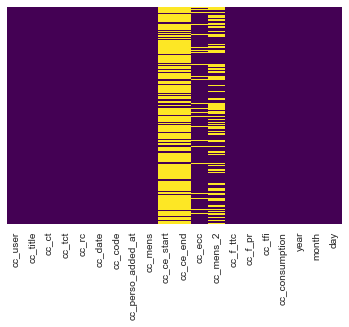

In [5]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Yellow color shows empty null values in the data set

### Droping unneccesary columns 

In [6]:
df.drop(['cc_user','cc_date','cc_ce_start','cc_ce_end','cc_perso_added_at','cc_f_ttc','cc_f_pr'],axis=1,inplace=True)

In [7]:
df.count()

cc_title          100000
cc_ct             100000
cc_tct            100000
cc_rc             100000
cc_code           100000
cc_mens           100000
cc_ecc             89175
cc_mens_2          55863
cc_tfi            100000
cc_consumption    100000
year              100000
month             100000
day               100000
dtype: int64

Total Records 

In [8]:
df=df.dropna()
df.isnull().sum()
df.count()

cc_title          55863
cc_ct             55863
cc_tct            55863
cc_rc             55863
cc_code           55863
cc_mens           55863
cc_ecc            55863
cc_mens_2         55863
cc_tfi            55863
cc_consumption    55863
year              55863
month             55863
day               55863
dtype: int64

Total Records available for processing

## Creating temp dataframe for processing

In [9]:
dft2=df
dft = df[df.cc_consumption<800]
df_dummies2 = pd.get_dummies(dft2)
df_dummies = pd.get_dummies(dft)
df_dummies['cc_mens']=df_dummies['cc_mens'].map({'True':1,'False':0})

# Exploratory Data Analysis

<AxesSubplot:>

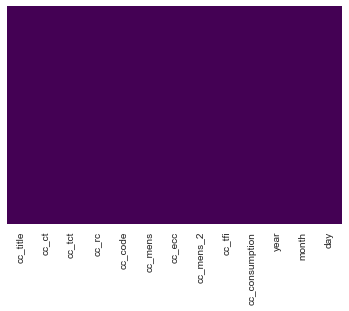

In [10]:
sns.heatmap(dft.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Plot shows Null Values in yellow if any

<AxesSubplot:>

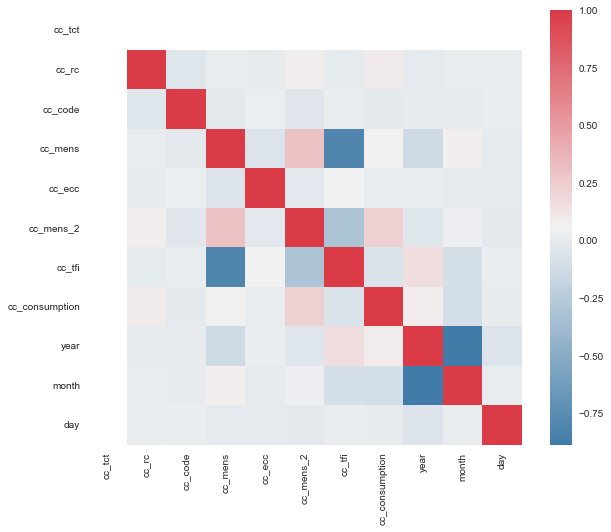

In [11]:
#Get Correlation of "consumption" with other variables:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

Checking correlation within data to see relationship between features, and the strength of that relationship 

Text(0.5, 1.0, 'title Distribution')

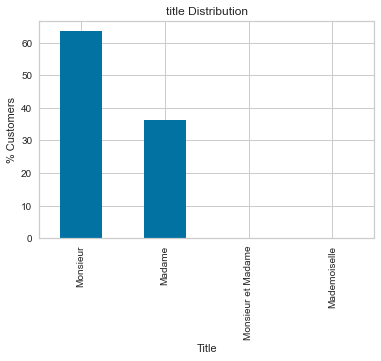

In [12]:

ax = (dft['cc_title'].value_counts()*100.0 /len(dft)).plot(kind='bar')
ax.set_ylabel('% Customers')
ax.set_xlabel('Title')
ax.set_ylabel('% Customers')
ax.set_title('title Distribution')


Data is populated with Mr and Mrs titles

In [13]:
dft["cc_title"].value_counts()

Monsieur              28454
Madame                16295
Monsieur et Madame       46
Mademoiselle              5
Name: cc_title, dtype: int64

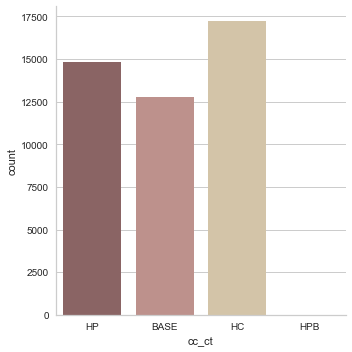

In [14]:
sns.catplot(x="cc_ct", kind="count", palette="pink", data=dft)

Majority of the data has cc_ct values of HP BASE and HC so values with HPB can be removed.  

<AxesSubplot:title={'center':'Box plot for consumpition by men and women'}, xlabel='cc_consumption', ylabel='cc_title_Madame'>

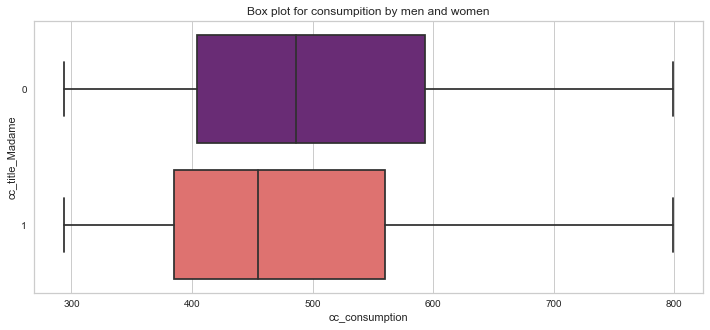

In [15]:
plt.figure(figsize=(12,5))
plt.title("Box plot for consumpition by men and women")
sns.boxplot(y="cc_title_Madame", x='cc_consumption', data =df_dummies , orient="h", palette = 'magma')

cc_consumption for men is more than women Men are denoted by 0 while women are denoted by 1

## Outliers
#### (the bane of Data science)

<AxesSubplot:title={'center':'Box plot for consumpition by men'}, xlabel='cc_consumption', ylabel='cc_title_Monsieur'>

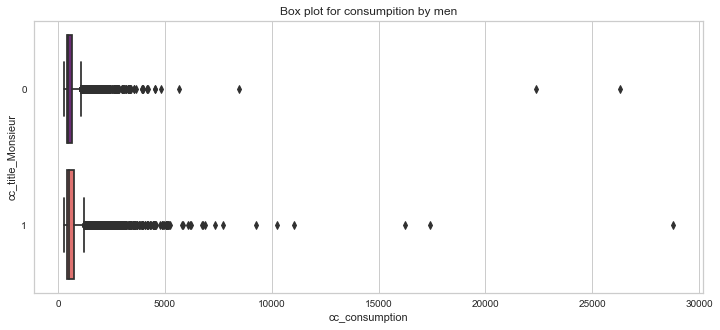

In [16]:
plt.figure(figsize=(12,5))
plt.title("Box plot for consumpition by men")
sns.boxplot(y="cc_title_Monsieur", x="cc_consumption", data =df_dummies2 , orient="h", palette = 'magma')

There are extreem outliers within the data. Maximum data is in range of 0-800. I have removed all the outliers 

Text(0.5, 1.0, 'Scatter plot of cc_code and cc_consumption')

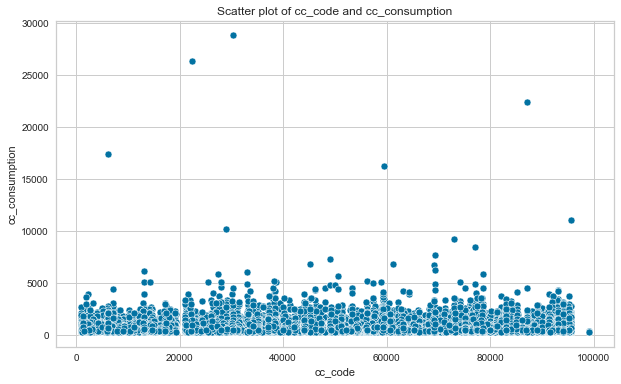

In [17]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='cc_code',y='cc_consumption',data=df,palette='magma')
ax.set_title('Scatter plot of cc_code and cc_consumption')


Outliers by location

In [19]:
dft3=df[df.cc_consumption<800]


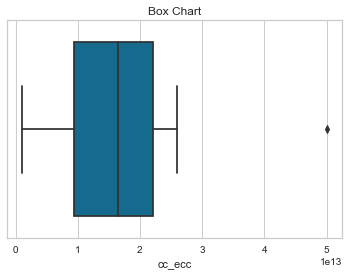

In [20]:
ax = sns.boxplot(x = dft3.cc_ecc)
ax.set(xlabel = 'cc_ecc', title = 'Box Chart');

Outliers by cc_ecc

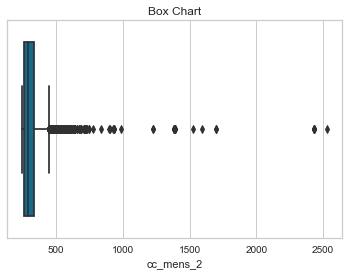

In [21]:
ax = sns.boxplot(x = dft3.cc_mens_2)
ax.set(xlabel = 'cc_mens_2', title = 'Box Chart');

Outliers by cc_men_2

### Creating X and Y array and encoding

I have handled Encoding and categorical data here.

In [22]:
dftrue=df
df=df[df.cc_consumption<800]
dft3=df[df.cc_consumption<800]


In [23]:
dft3 = dft3[dft3.cc_mens_2<500]
dft3 = dft3[dft3.cc_ecc<2.915137e+13]
pred=dft3['cc_consumption']
dft3=dft3.drop(columns='cc_consumption')

X = dft3.iloc[:,:-1].values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])
le1 = LabelEncoder()
X[:, 1] = le1.fit_transform(X[:, 1])
le5 = LabelEncoder()
X[:, 5] = le5.fit_transform(X[:,5])
Y=np.array(pred)


I have tried OneHotencoding but ML model results had detoriated so i decided to go with label encoding for now.

Text(0.5, 1.0, 'Violin plot of consumption vs Title')

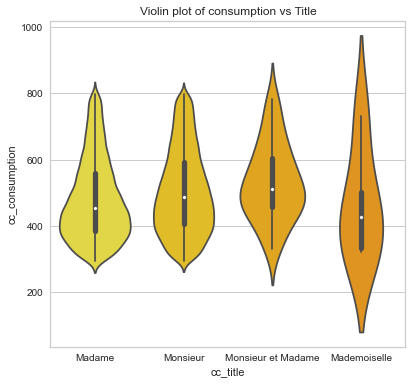

In [24]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='cc_title', y='cc_consumption',data=dft,palette='Wistia',ax=ax)
ax.set_title('Violin plot of consumption vs Title')

Mademoiselle shows the highes range expansion and has the maximum cc_consumption. Madame and Monsieur have similar consumption. Most frequent cc_consumption is in Range of 400-480 

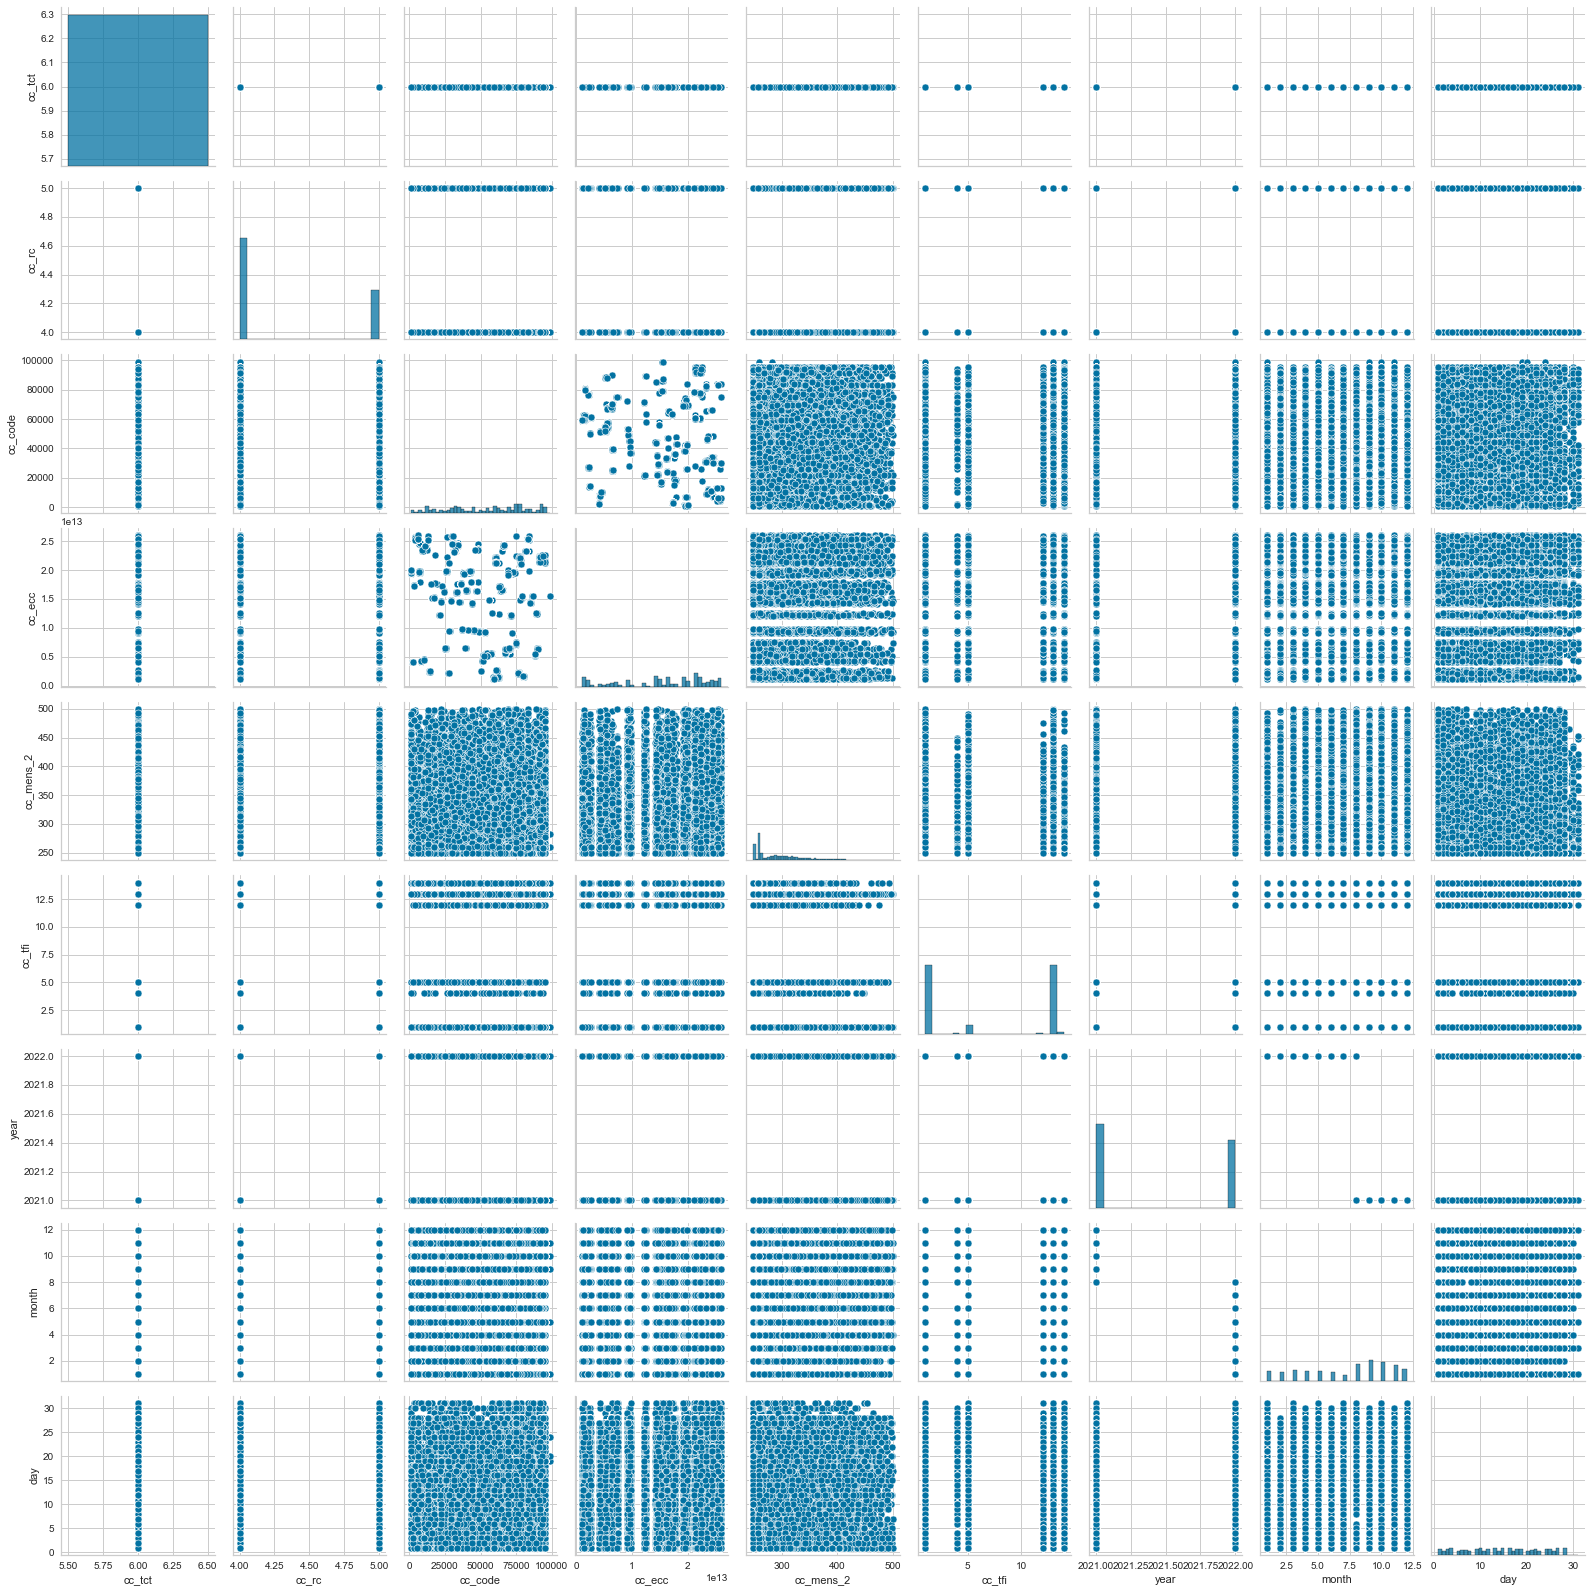

In [25]:
df3=dft3
df3=df3.drop(columns=("cc_mens"))
sns.pairplot(df3)

To see Inter-column relationship

# Train Test Split

In [26]:
dft3

,cc_title,cc_ct,cc_tct,cc_rc,cc_code,cc_mens,cc_ecc,cc_mens_2,cc_tfi,year,month,day
1,Madame,HP,6,5,77468,True,2.214052e+13,395.762727,1,2021,8,15
5,Madame,HP,6,5,68224,True,6.342836e+12,249.000000,1,2021,9,25
7,Monsieur,HP,6,5,78464,True,2.119899e+13,381.000000,1,2021,8,22
8,Monsieur,BASE,6,4,76178,True,2.112446e+12,290.000000,1,2021,12,8
9,Madame,BASE,6,4,3022,True,1.735268e+13,249.000000,1,2021,9,13
...,...,...,...,...,...,...,...,...,...,...,...,...
99989,Monsieur,HC,6,4,17166,False,1.521968e+13,259.528182,13,2021,12,12
99991,Monsieur,HP,6,5,40080,True,1.646758e+13,249.000000,4,2021,11,10
99992,Monsieur,HC,6,4,17242,False,1.521158e+13,449.250000,13,2021,10,12
99993,Monsieur,BASE,6,4,59378,True,1.118669e+12,344.430000,1,2022,5,4


Visualising the Data

In [27]:
date_objects = [datetime.strptime(str(date), '%Y-%m-%d').date() for date in dates]

In [28]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state =0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Creating test and Train split

In [34]:
X[0]

In [ ]:
df = df.reset_index()

### Random Forest

In [29]:
forest = RandomForestRegressor(n_estimators= 800,
  min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'auto',
 max_depth= 100,
 bootstrap= True)
forest.fit(X_train,y_train)
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)


rmset=mean_squared_error(y_train,forest_train_pred)
rmsetest=mean_squared_error(y_test,forest_test_pred)
print("Root Mean Squared Error",rmset**.5) 

print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))


Root Mean Squared Error 39.67392781459278
R2 train data: 0.901, R2 test data: 0.267


<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

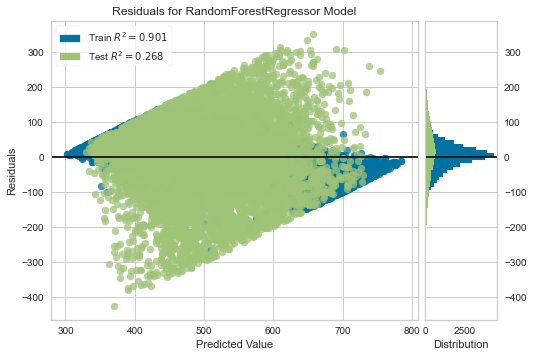

In [306]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(forest) 
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  
visualizer.show("Residual_Random_Forest.jpg")

The Residual graph shows the performance of the model. The more data distributed closer to 0 the better it is. Training distribution is centered around 0 which is a good sign. But Testing distribution is flat yet centerd around 0. The major difference in R2 score shows the signs of over fitting which i can try to resolve with more features.
I have already done multi-parameter testing to find the best available parameter. They are not part of this file. 

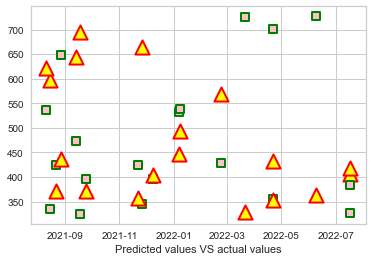

In [37]:
for i in range(1,20):
    plt.scatter(date_objects[i], df.cc_consumption[i], c ="pink",
            linewidths = 2,
            marker ="s",
            edgecolor ="green",
            s = 50)
    plt.scatter(date_objects[i],forest_train_pred[i], c ="yellow",
            linewidths = 2,
            marker ="^",
            edgecolor ="red",
            s = 200)
    plt.xlabel('Predicted values VS actual values')    

Triangle is Predicted value Square is Actual Value

In [38]:
 df.cc_consumption[500]

496

### Linear regressor

In [39]:
lr = LinearRegression().fit(X_train,y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

from sklearn.metrics import mean_squared_error
print("RMSE of Test",(mean_squared_error(y_test,y_test_pred))**.5)

print("R2 of test", r2_score(y_test,y_test_pred))
print("test score",lr.score(X_test,y_test))

print("R2 of train", r2_score(y_train,y_train_pred))
print("train score",lr.score(X_train,y_train))

RMSE of Test 121.0698177599112
R2 of test 0.05322367675344919
test score 0.05322367675344919
R2 of train 0.06630510821437208
train score 0.06630510821437208


<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

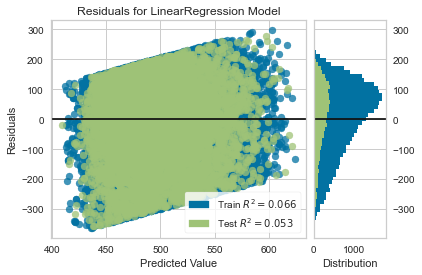

In [40]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(lr) 
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  
visualizer.show("Residual_LR.jpg")

Training distribution is skewed while testing distribution is completely flat.

Text(0.5, 0, 'Predicted values VS actual values')

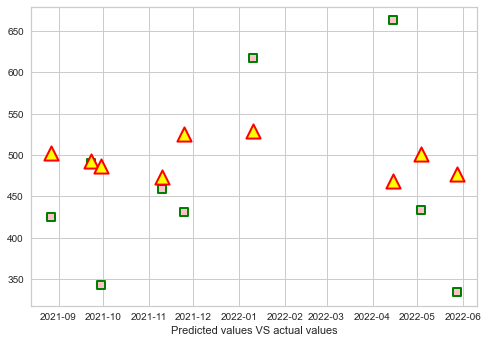

In [310]:
for i in range(496,505):
    plt.scatter(date_objects[i], df.cc_consumption[i], c ="pink",
            linewidths = 2,
            marker ="s",
            edgecolor ="green",
            s = 50)
    plt.scatter(date_objects[i],y_train_pred[i], c ="yellow",
            linewidths = 2,
            marker ="^",
            edgecolor ="red",
            s = 200)
plt.xlabel('Predicted values VS actual values')    

Triangle is Predicted value Square is Actual Value

### SVM regressor

In [11]:
from sklearn.svm import SVR
rr = SVR(kernel = 'rbf')
rr.fit(X_train,y_train)
y_train_pred = rr.predict(X_train)
y_test_pred = rr.predict(X_test)

print(" test score ", rr.score(X_test,y_test))
print("RMSE of Test",(mean_squared_error(y_test,y_test_pred))**.5)

print("R2 of test", r2_score(y_test,y_test_pred))
print("test score",rr.score(X_test,y_test))

print("R2 of train", r2_score(y_train,y_train_pred))
print("train score",rr.score(X_train,y_train))

 test score  0.08792274451367832
RMSE of Test 118.83052265098321
R2 of test 0.08792274451367832
test score 0.08792274451367832
R2 of train 0.10139056839926397
train score 0.10139056839926397


<AxesSubplot:title={'center':'Residuals for SVR Model'}, xlabel='Predicted Value', ylabel='Residuals'>

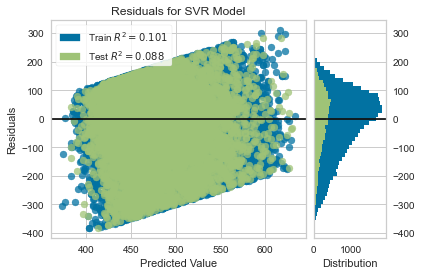

In [12]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(rr) 
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  
visualizer.show("Residual_SVR.jpg")

Both testing and training distribution are very off.

Text(0.5, 0, 'Predicted values VS actual values')

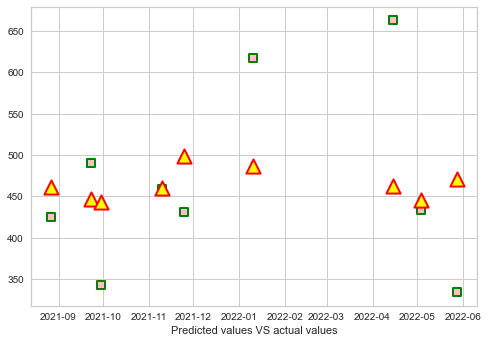

In [321]:
for i in range(496,505):
    plt.scatter(date_objects[i], df.cc_consumption[i], c ="pink",
            linewidths = 2,
            marker ="s",
            edgecolor ="green",
            s = 50)
    plt.scatter(date_objects[i],y_train_pred[i], c ="yellow",
            linewidths = 2,
            marker ="^",
            edgecolor ="red",
            s = 200)
plt.xlabel('Predicted values VS actual values')    

Triangle is Predicted value Square is Actual Value

### GradientBoostingRegressor

In [314]:
from sklearn.ensemble import GradientBoostingRegressor


GBoost = GradientBoostingRegressor(n_estimators=800, learning_rate=0.05,
                                   max_depth=10, max_features='sqrt',
                                   min_samples_leaf=10, min_samples_split=5, 
                                   loss='huber', random_state =5).fit(X_train,y_train)


y_train_pred = GBoost.predict(X_train)
y_test_pred = GBoost.predict(X_test)

rmset=mean_squared_error(y_train,y_train_pred)
rmsetest=mean_squared_error(y_test,y_test_pred)
print("Root mean Squared Error training",rmset**.5) 

print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,y_train_pred),
r2_score(y_test,y_test_pred)))

Root mean Squared Error training 85.37811730503203
R2 train data: 0.539, R2 test data: 0.248


<AxesSubplot:title={'center':'Residuals for GradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

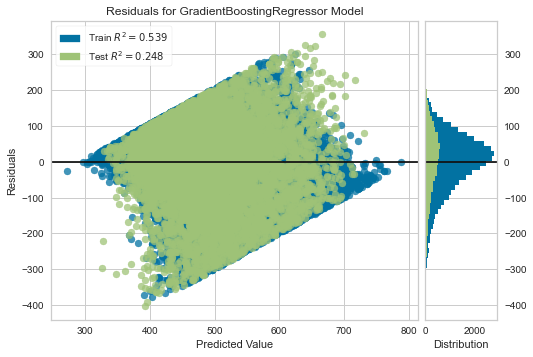

In [319]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(GBoost) 
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  
visualizer.show("Residual_SVR.jpg")

With better parameter tuning this can show better results. Currently GBoost has least chances of Overfitting.

Text(0.5, 0, 'Predicted values VS actual values')

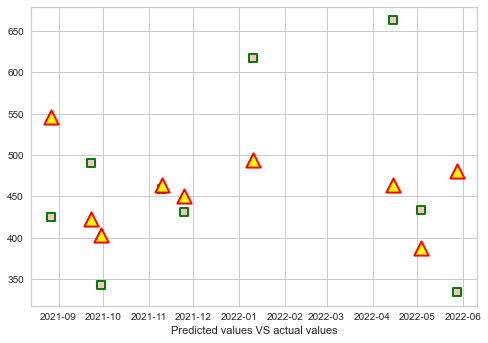

In [316]:
for i in range(496,505):
    plt.scatter(date_objects[i], df.cc_consumption[i], c ="pink",
            linewidths = 2,
            marker ="s",
            edgecolor ="green",
            s = 50)
    plt.scatter(date_objects[i],y_train_pred[i], c ="yellow",
            linewidths = 2,
            marker ="^",
            edgecolor ="red",
            s = 200)
plt.xlabel('Predicted values VS actual values')    

Triangle is Predicted value Square is Actual Value

## R2 Score Analysis

<BarContainer object of 4 artists>

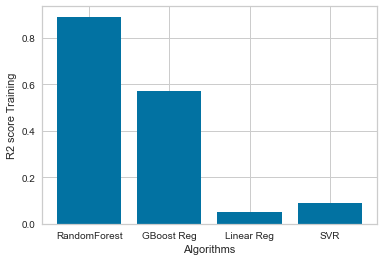

In [13]:
a=[0.89,0.57,0.05,0.09]
b=['RandomForest','GBoost Reg','Linear Reg','SVR']
plt.xlabel('Algorithms')
plt.ylabel('R2 score Training')
plt.bar(b,a)


Random Forest has out performed all other algorithms. Linear Regression has performed the Worst 

<BarContainer object of 4 artists>

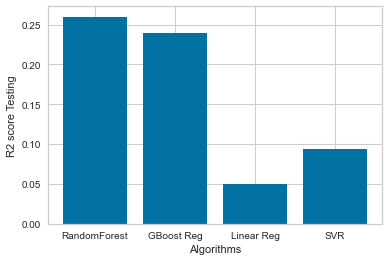

In [14]:
a=[0.26,0.24,0.05,0.094]
b=['RandomForest','GBoost Reg','Linear Reg','SVR']
plt.xlabel('Algorithms')
plt.ylabel('R2 score Testing')
plt.bar(b,a)


Random Forest has out performed all other algorithms. But this performance on Test set is not adequate. Further new data can Improve this

### RMSE Analysis

<BarContainer object of 4 artists>

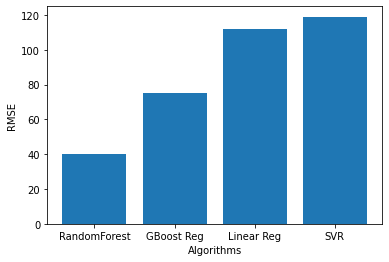

In [312]:
a=[40,75,112,119]
b=['RandomForest','GBoost Reg','Linear Reg','SVR']
plt.xlabel('Algorithms')
plt.ylabel('RMSE')
plt.bar(b,a)

Random Forest has the least Root mean square error. Linear regression and SVR have a very dissapointing performance

# New prediction
#### Monsieur , base , location code 57401, 	cc_tct 5, cc_rc 4
#### Input Format  0 cc_title	1 cc_ct	 2cc_tct	3cc_rc	4cc_code	5cc_mens	6cc_ecc	7cc_mens_2	8cc_f_ttc	9cc_f_pr	10year	month	day

In [166]:
dft.head()


,cc_title,cc_ct,cc_tct,cc_rc,cc_code,cc_mens,cc_ecc,cc_mens_2,cc_f_ttc,cc_f_pr,cc_tfi,cc_consumption
1,Madame,HP,6,5,77468,True,2.214052e+13,395.762727,1493.40,-106.40,1,507
5,Madame,HP,6,5,68224,True,6.342836e+12,249.000000,716.79,316.79,1,335
7,Monsieur,HP,6,5,78464,True,2.119899e+13,381.000000,1589.93,95.80,1,726
8,Monsieur,BASE,6,4,76178,True,2.112446e+12,290.000000,238.47,-18.23,1,345
9,Madame,BASE,6,4,3022,True,1.735268e+13,249.000000,607.67,-24.43,1,425


In [160]:
print(list(le1.classes_))
print("0,1,2,3")

['BASE', 'HC', 'HP', 'HPB']
0,1,2,3


In [161]:
print(list(le.classes_))
print("0,1,2,3")

['Madame', 'Mademoiselle', 'Monsieur', 'Monsieur et Madame']
0,1,2,3


In [162]:
print(list(le5.classes_))

[False, True]


In [317]:
l=np.array([[3,0,6,5,64801,1,2.214052e+13,395.762727,1493.40,-106.40,1]])
tt=sc.transform(l)
tt=forest.predict(tt)
tt=tt.reshape(-1,1)


In [318]:
print("Prediction",tt[0][0])

Prediction 633.21625


# Experimentation (Testing New Ideas)

<AxesSubplot:title={'center':'Feature Importances of 11 Features using RandomForestRegressor'}, xlabel='feature importance'>

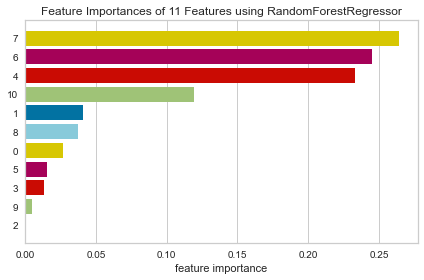

In [41]:
from yellowbrick.model_selection import FeatureImportances
viz = FeatureImportances(forest,relative=False)
#fit on train dataset
viz.fit(X_train, y_train)
#show plot and save at output path
viz.show("feature_importance.jpg")
